## MLB attendance analysis and correlation with household income & population density

Import libraries and load data (census tracts and MLB stadiums)

In [1]:
import geopandas as gpd
from pygris import tracts, states
import pandas as pd
from pygris.data import get_census
import matplotlib.pyplot as plt
import seaborn as sns

# Get all state FIPS codes except for Alaska and Hawaii
all_states = states()
fips = all_states[~all_states['STUSPS'].isin(['AK', 'HI'])]['STATEFP'].tolist()

all_census_tracts = gpd.GeoDataFrame()

for state_fips in fips:
    state_tracts = tracts(state=state_fips, year=2021, cb=True)
    all_census_tracts = pd.concat([all_census_tracts, state_tracts], ignore_index=True)

all_census_tracts = all_census_tracts.set_crs(epsg=4326, allow_override=True)

# Load MLB stadiums data
stadium_csv_path = '/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/data/mlb_stadiums_geocoded_logos.csv'
stadiums_gdf = gpd.read_file(stadium_csv_path)
stadiums_gdf = gpd.GeoDataFrame(stadiums_gdf, geometry=gpd.points_from_xy(stadiums_gdf.Longitude, stadiums_gdf.Latitude), crs="EPSG:4326")

print("Loaded census tracts and MLB stadiums data.")
print(f"Number of census tracts: {len(all_census_tracts)}")
print(f"Number of stadiums: {len(stadiums_gdf)}")

Using the default year of 2021
Loaded census tracts and MLB stadiums data.
Number of census tracts: 84617
Number of stadiums: 30


Create buffers around MLB stadiums and join with census tracts

In [2]:
# Create buffers around stadiums
stadiums_gdf = stadiums_gdf.to_crs(epsg=3857)
buffer_distance = 32000  # 20 miles in meters
stadiums_gdf['buffer'] = stadiums_gdf.buffer(buffer_distance)
stadiums_gdf = stadiums_gdf.set_geometry('buffer').to_crs(epsg=4326)

# Join census tracts with stadium buffers
all_census_tracts = all_census_tracts.to_crs(epsg=4326)
all_tracts_in_buffers = gpd.sjoin(all_census_tracts, stadiums_gdf[['buffer', 'Team']], how='inner', op='intersects')

print(f"Number of census tracts within stadium buffers: {len(all_tracts_in_buffers)}")

/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Number of census tracts within stadium buffers: 23300


In [7]:
# Chunk 3: Fetch and merge census data

import requests
from pygris.data import get_census

# Define census variables
variables = [
    "B01003_001E",  # Total Population
    "B19013_001E",  # Median Household Income
]

# Filter out non-state FIPS codes
valid_fips = [fips for fips in fips if fips not in ['60', '66', '69', '78']]

# Fetch census data state by state
census_data_list = []
for state_fips in valid_fips:
    try:
        state_data = get_census(
            dataset='acs/acs5',
            variables=variables,
            year=2021,
            params={
                "for": "tract:*",
                "in": f"state:{state_fips}"
            },
            guess_dtypes=True,
            return_geoid=True
        )
        census_data_list.append(state_data)
        print(f"Successfully fetched data for state FIPS: {state_fips}")
    except Exception as e:
        print(f"Error fetching data for state FIPS {state_fips}: {str(e)}")

# Check if we got any data
if not census_data_list:
    print("No census data was successfully retrieved. Please check your internet connection and Census API access.")
else:
    # Combine all state data
    census_data = pd.concat(census_data_list, ignore_index=True)

    # Merge census data with tracts in buffers
    all_tracts_in_buffers = all_tracts_in_buffers.merge(census_data, on='GEOID')

    # Calculate area and population density
    all_tracts_in_buffers['area_km2'] = all_tracts_in_buffers.geometry.to_crs(epsg=3857).area / 1e6
    all_tracts_in_buffers['population_density'] = all_tracts_in_buffers['B01003_001E'] / all_tracts_in_buffers['area_km2']

    print("Census data merged and population density calculated.")
    print(all_tracts_in_buffers[['Team', 'B01003_001E', 'B19013_001E', 'area_km2', 'population_density']].head())

# Print the shape of the resulting dataframe
print(f"Shape of all_tracts_in_buffers: {all_tracts_in_buffers.shape}")

Successfully fetched data for state FIPS: 56
Successfully fetched data for state FIPS: 24
Successfully fetched data for state FIPS: 05
Successfully fetched data for state FIPS: 38
Successfully fetched data for state FIPS: 10
Successfully fetched data for state FIPS: 35
Successfully fetched data for state FIPS: 49
Successfully fetched data for state FIPS: 54
Successfully fetched data for state FIPS: 20
Successfully fetched data for state FIPS: 13
Successfully fetched data for state FIPS: 28
Successfully fetched data for state FIPS: 27
Successfully fetched data for state FIPS: 33
Successfully fetched data for state FIPS: 29
Successfully fetched data for state FIPS: 16
Successfully fetched data for state FIPS: 46
Successfully fetched data for state FIPS: 42
Successfully fetched data for state FIPS: 40
Successfully fetched data for state FIPS: 18
Successfully fetched data for state FIPS: 34
Successfully fetched data for state FIPS: 31
Successfully fetched data for state FIPS: 08
Successful

Aggregate data by stadium

In [10]:
# Chunk 4: Aggregate data by stadium

# Function to clean and convert attendance data
def clean_attendance(attendance_str):
    return pd.to_numeric(attendance_str.replace(',', ''), errors='coerce')

# Aggregate data by stadium
stadium_data = all_tracts_in_buffers.groupby('Team').agg({
    'population_density': 'mean',
    'B19013_001E': 'mean',  # Average median household income
}).reset_index()

stadium_data = stadium_data.rename(columns={
    'B19013_001E': 'avg_median_income',
})

# Merge with attendance data and clean the attendance figures
stadium_data = stadium_data.merge(stadiums_gdf[['Team', 'AttendancePerGame_2023']], on='Team')
stadium_data['AttendancePerGame_2023'] = stadium_data['AttendancePerGame_2023'].apply(clean_attendance)

print("Data aggregated by stadium.")
print(stadium_data.head())

# Check for any remaining non-numeric values
non_numeric = stadium_data[pd.to_numeric(stadium_data['AttendancePerGame_2023'], errors='coerce').isna()]
if not non_numeric.empty:
    print("Warning: Some attendance values could not be converted to numbers:")
    print(non_numeric[['Team', 'AttendancePerGame_2023']])

Data aggregated by stadium.
                   Team  population_density  avg_median_income  \
0  Arizona Diamondbacks         1515.264822       70559.493045   
1        Atlanta Braves         1124.781397       88087.404223   
2     Baltimore Orioles         1561.927566       83814.642722   
3        Boston Red Sox         2962.651444      108112.737864   
4          Chicago Cubs         3697.704069       75788.206969   

   AttendancePerGame_2023  
0                   24212  
1                   39401  
2                   23911  
3                   32989  
4                   34261  


Calculate correlations & visualize relationships

Correlations with Attendance:
population_density        0.244509
avg_median_income         0.058776
AttendancePerGame_2023    1.000000
Name: AttendancePerGame_2023, dtype: float64


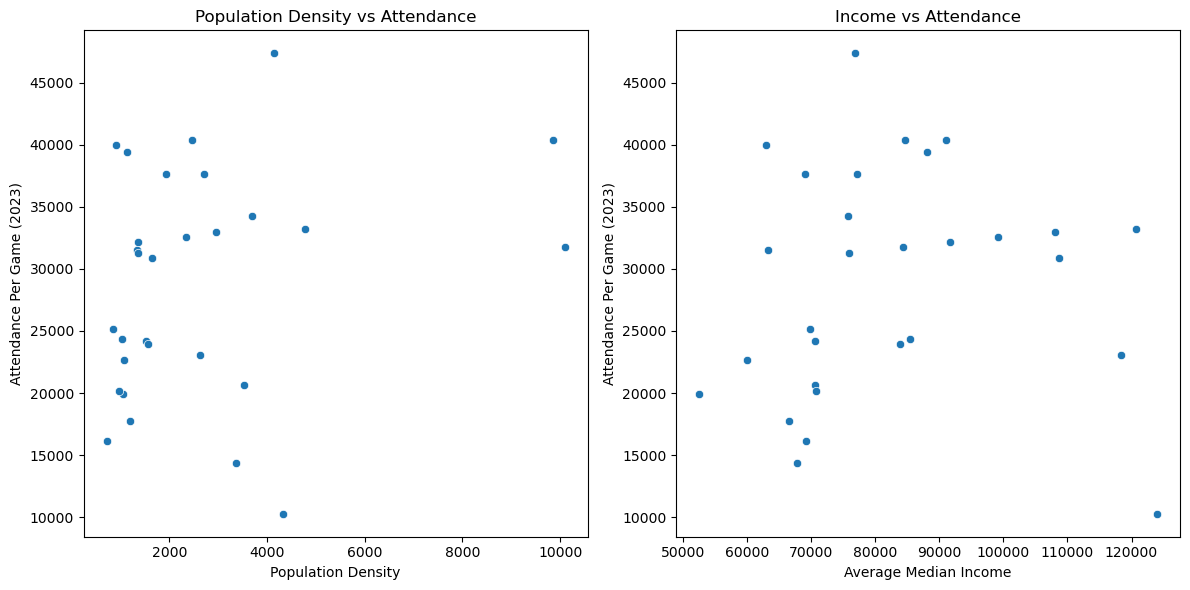


Summary Statistics:
       population_density  avg_median_income  AttendancePerGame_2023
count           29.000000          29.000000               29.000000
mean          2639.254894       82287.307308            28831.517241
std           2341.159929       18914.944704             9125.601388
min            714.775512       52472.393204            10276.000000
25%           1124.781397       69124.965261            22643.000000
50%           1652.565250       76753.944081            31272.000000
75%           3370.516197       90975.883475            34261.000000
max          10090.608340      123993.821727            47371.000000


In [12]:
# Chunk 5: Calculate correlations and visualize relationships

# Ensure all data is numeric
numeric_cols = ['population_density', 'avg_median_income', 'AttendancePerGame_2023']
stadium_data_numeric = stadium_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate correlations
correlations = stadium_data_numeric.corr()

print("Correlations with Attendance:")
print(correlations['AttendancePerGame_2023'])

# Visualize relationships
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=stadium_data_numeric, x='population_density', y='AttendancePerGame_2023', ax=axes[0])
axes[0].set_xlabel('Population Density')
axes[0].set_ylabel('Attendance Per Game (2023)')
axes[0].set_title('Population Density vs Attendance')

sns.scatterplot(data=stadium_data_numeric, x='avg_median_income', y='AttendancePerGame_2023', ax=axes[1])
axes[1].set_xlabel('Average Median Income')
axes[1].set_ylabel('Attendance Per Game (2023)')
axes[1].set_title('Income vs Attendance')

plt.tight_layout()
plt.savefig('/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/outputs/mlb_attendance_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(stadium_data_numeric.describe())

Calc summary statistics

In [13]:
# Print summary statistics
print("\nSummary Statistics:")
print(stadium_data.describe())

# Identify top and bottom stadiums for each metric
metrics = ['population_density', 'avg_median_income', 'AttendancePerGame_2023']
for metric in metrics:
    print(f"\nTop 5 stadiums by {metric}:")
    print(stadium_data.nlargest(5, metric)[['Team', metric]])
    print(f"\nBottom 5 stadiums by {metric}:")
    print(stadium_data.nsmallest(5, metric)[['Team', metric]])


Summary Statistics:
       population_density  avg_median_income  AttendancePerGame_2023
count           29.000000          29.000000               29.000000
mean          2639.254894       82287.307308            28831.517241
std           2341.159929       18914.944704             9125.601388
min            714.775512       52472.393204            10276.000000
25%           1124.781397       69124.965261            22643.000000
50%           1652.565250       76753.944081            31272.000000
75%           3370.516197       90975.883475            34261.000000
max          10090.608340      123993.821727            47371.000000

Top 5 stadiums by population_density:
                    Team  population_density
17         New York Mets        10090.608340
18      New York Yankees         9854.244953
23  San Francisco Giants         4768.976031
19     Oakland Athletics         4332.467979
13   Los Angeles Dodgers         4151.659896

Bottom 5 stadiums by population_density:
       

In [17]:
import sys
!{sys.executable} -m pip install contextily

  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/d2/84/dbcd682289fe8fa3f7c16318e06a7626608f767a9a163954df58f245adef/contextily-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for mercantile from https://files.pythonhosted.org/packages/b2/d6/de0cc74f8d36976aeca0dd2e9cbf711882ff8e177495115fd82459afdc4d/mercantile-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/4f/f7/e4ac8f3dfd11e4c718e9281a7e41417462100bc0bc575059a8eeab1e8bf0/rasterio-1.3.10-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for snuggs>=1.4.1 from https://files.pythonhosted.org/packages/cc/0e/d27d6e806d6c0d1a2cfdc5d1f088e42339a0a54a09c3343f7f81ec8947ea/snuggs-1.

In [18]:
import contextily as ctx
print("Contextily imported successfully!")

Contextily imported successfully!


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Arizona Diamondbacks


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Atlanta Braves


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Baltimore Orioles


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Boston Red Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Chicago Cubs


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Chicago White Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Cincinnati Reds


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Cleveland Guardians


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Colorado Rockies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Detroit Tigers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Houston Astros


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Kansas City Royals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Los Angeles Angels


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Los Angeles Dodgers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Miami Marlins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Milwaukee Brewers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Minnesota Twins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for New York Mets


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for New York Yankees


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Oakland Athletics


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Philadelphia Phillies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Pittsburgh Pirates


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for San Diego Padres


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for San Francisco Giants


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Seattle Mariners


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for St. Louis Cardinals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Tampa Bay Rays


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Texas Rangers
Error creating map for Toronto Blue Jays: aspect must be finite and positive 


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3143418039.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the f

Created map for Washington Nationals
All team stadium density maps have been created.


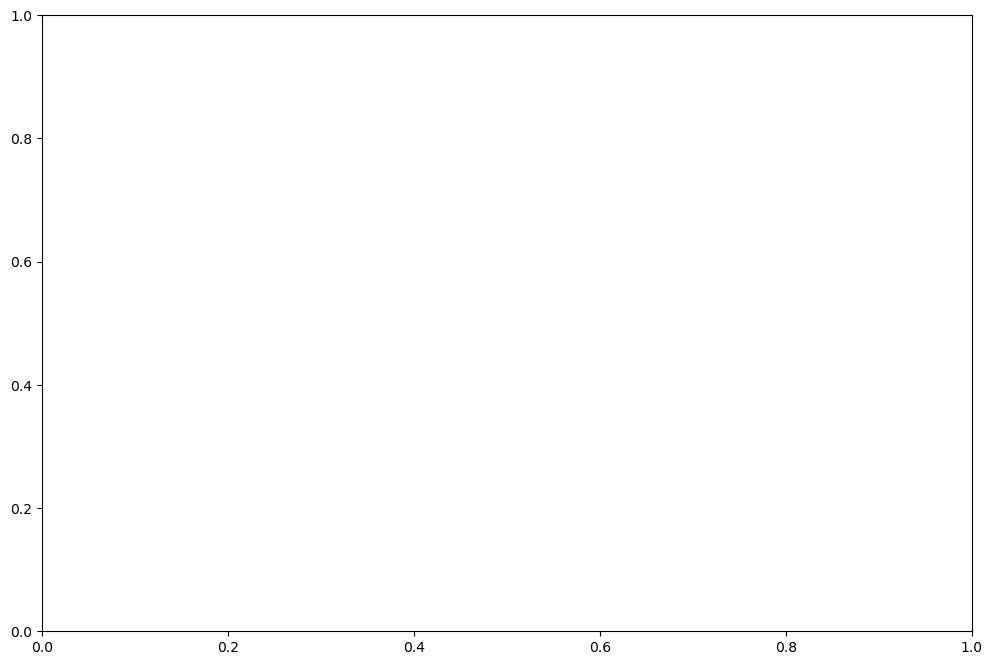

In [30]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

def plot_team_density(team_name, stadium_gdf, tracts_gdf):
    # Filter tracts for the specific team
    team_tracts = tracts_gdf[tracts_gdf['Team'] == team_name]
    
    # Get the stadium point
    stadium_point = stadium_gdf[stadium_gdf['Team'] == team_name]
    
    # Ensure we have a Point geometry
    geometry = stadium_point.geometry.values[0]
    if geometry.type == 'MultiPoint':
        geometry = list(geometry.geoms)[0]  # Take the first point
    elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
        geometry = geometry.centroid  # Use centroid for polygon geometries
    
    if not isinstance(geometry, Point):
        print(f"Error: Geometry for {team_name} is not a point and could not be converted.")
        return
    
    x, y = geometry.x, geometry.y
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot tracts with population density
    team_tracts.plot(column='population_density', cmap='viridis', legend=True, 
                     ax=ax, legend_kwds={'label': 'Population Density (people/km²)'})
    
    # Plot stadium location using matplotlib scatter for better control over marker size
    ax.scatter(x, y, color='red', s=100, zorder=5)  # Adjust 's' for marker size (s=100 is reasonable)
    
    # Set title
    ax.set_title(f'Population Density around {team_name} Stadium', fontsize=16)
    
    # Set aspect ratio safely
    try:
        bounds = team_tracts.total_bounds
        y_coord = np.mean([bounds[1], bounds[3]])
        aspect = 1 / np.cos(y_coord * np.pi / 180)
        if np.isfinite(aspect) and aspect > 0:
            ax.set_aspect(aspect)
        else:
            ax.set_aspect('equal')
    except Exception:
        ax.set_aspect('equal')
    
    # Remove axis labels
    ax.set_axis_off()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f'population_density_{team_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Ensure the CRS is set correctly for both datasets
all_tracts_in_buffers = all_tracts_in_buffers.to_crs(epsg=4326)
stadiums_gdf = stadiums_gdf.to_crs(epsg=4326)

# Create a plot for each team
for team in stadiums_gdf['Team'].unique():
    try:
        plot_team_density(team, stadiums_gdf, all_tracts_in_buffers)
        print(f"Created map for {team}")
    except Exception as e:
        print(f"Error creating map for {team}: {str(e)}")

print("All team stadium density maps have been created.")

Correlations with Attendance:
population_density        0.244509
avg_median_income         0.058776
AttendancePerGame_2023    1.000000
Name: AttendancePerGame_2023, dtype: float64

Linear Regression Model: Population Density
                              OLS Regression Results                              
Dep. Variable:     AttendancePerGame_2023   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.025
Method:                     Least Squares   F-statistic:                     1.717
Date:                    Thu, 27 Jun 2024   Prob (F-statistic):              0.201
Time:                            23:33:44   Log-Likelihood:                -304.19
No. Observations:                      29   AIC:                             612.4
Df Residuals:                          27   BIC:                             615.1
Df Model:                               1                                         
Covariance Type:            

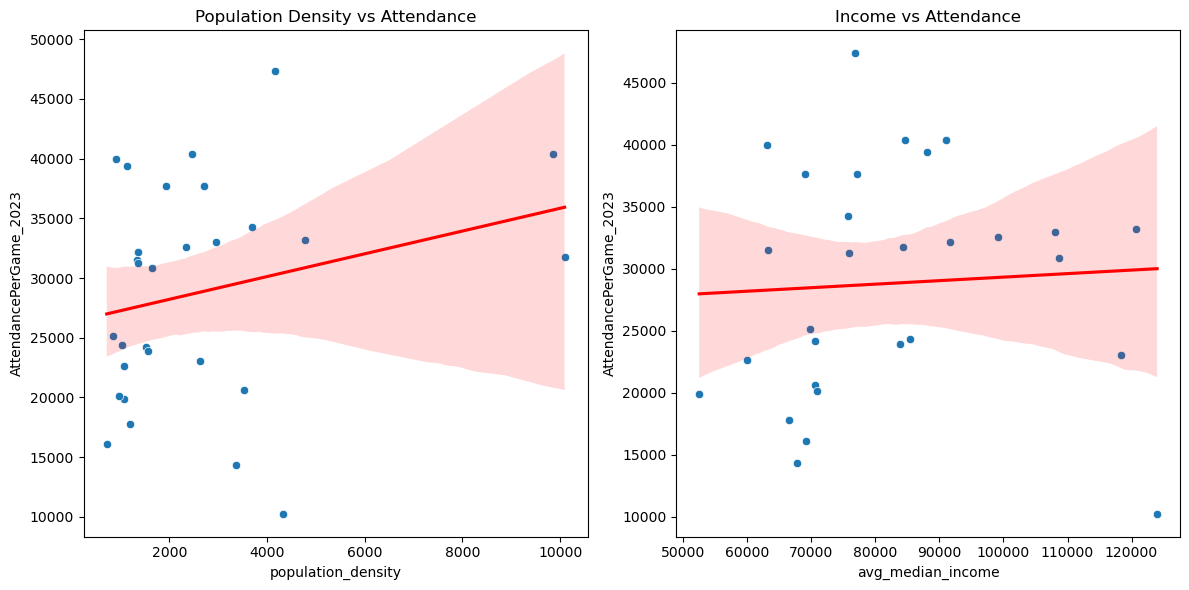


Summary Statistics:
       population_density  avg_median_income  AttendancePerGame_2023
count           29.000000          29.000000               29.000000
mean          2639.254894       82287.307308            28831.517241
std           2341.159929       18914.944704             9125.601388
min            714.775512       52472.393204            10276.000000
25%           1124.781397       69124.965261            22643.000000
50%           1652.565250       76753.944081            31272.000000
75%           3370.516197       90975.883475            34261.000000
max          10090.608340      123993.821727            47371.000000


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Ensure all data is numeric
numeric_cols = ['population_density', 'avg_median_income', 'AttendancePerGame_2023']
stadium_data_numeric = stadium_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
stadium_data_numeric = stadium_data_numeric.dropna()

# Calculate correlations
correlations = stadium_data_numeric.corr()
print("Correlations with Attendance:")
print(correlations['AttendancePerGame_2023'])

# Single Variable Linear Regression
X_density = stadium_data_numeric[['population_density']]
y = stadium_data_numeric['AttendancePerGame_2023']
X_income = stadium_data_numeric[['avg_median_income']]

model_density = sm.OLS(y, sm.add_constant(X_density)).fit()
model_income = sm.OLS(y, sm.add_constant(X_income)).fit()

print("\nLinear Regression Model: Population Density")
print(model_density.summary())
print("\nLinear Regression Model: Average Median Income")
print(model_income.summary())

# Multiple Regression Analysis
X = stadium_data_numeric[['population_density', 'avg_median_income']]
model = sm.OLS(y, sm.add_constant(X)).fit()

print("\nMultiple Regression Model")
print(model.summary())

# Visualize relationships
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=stadium_data_numeric, x='population_density', y='AttendancePerGame_2023', ax=axes[0])
axes[0].set_xlabel('Population Density')
axes[0].set_ylabel('Attendance Per Game (2023)')
axes[0].set_title('Population Density vs Attendance')
sns.regplot(data=stadium_data_numeric, x='population_density', y='AttendancePerGame_2023', ax=axes[0], scatter=False, color='red')

sns.scatterplot(data=stadium_data_numeric, x='avg_median_income', y='AttendancePerGame_2023', ax=axes[1])
axes[1].set_xlabel('Average Median Income')
axes[1].set_ylabel('Attendance Per Game (2023)')
axes[1].set_title('Income vs Attendance')
sns.regplot(data=stadium_data_numeric, x='avg_median_income', y='AttendancePerGame_2023', ax=axes[1], scatter=False, color='red')

plt.tight_layout()
plt.savefig('mlb_attendance_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(stadium_data_numeric.describe())

/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Arizona Diamondbacks


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Atlanta Braves


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Baltimore Orioles


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Boston Red Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Chicago Cubs


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Chicago White Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Cincinnati Reds


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Cleveland Guardians


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Colorado Rockies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Detroit Tigers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Houston Astros


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Kansas City Royals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Los Angeles Angels


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Los Angeles Dodgers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Miami Marlins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Milwaukee Brewers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Minnesota Twins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for New York Mets


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for New York Yankees


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Oakland Athletics


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Philadelphia Phillies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Pittsburgh Pirates


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for San Diego Padres


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for San Francisco Giants


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Seattle Mariners


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for St. Louis Cardinals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Tampa Bay Rays


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':


Created map for Texas Rangers
Error creating map for Toronto Blue Jays: aspect must be finite and positive 


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3901444694.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the f

Created map for Washington Nationals
All team stadium density maps have been created.


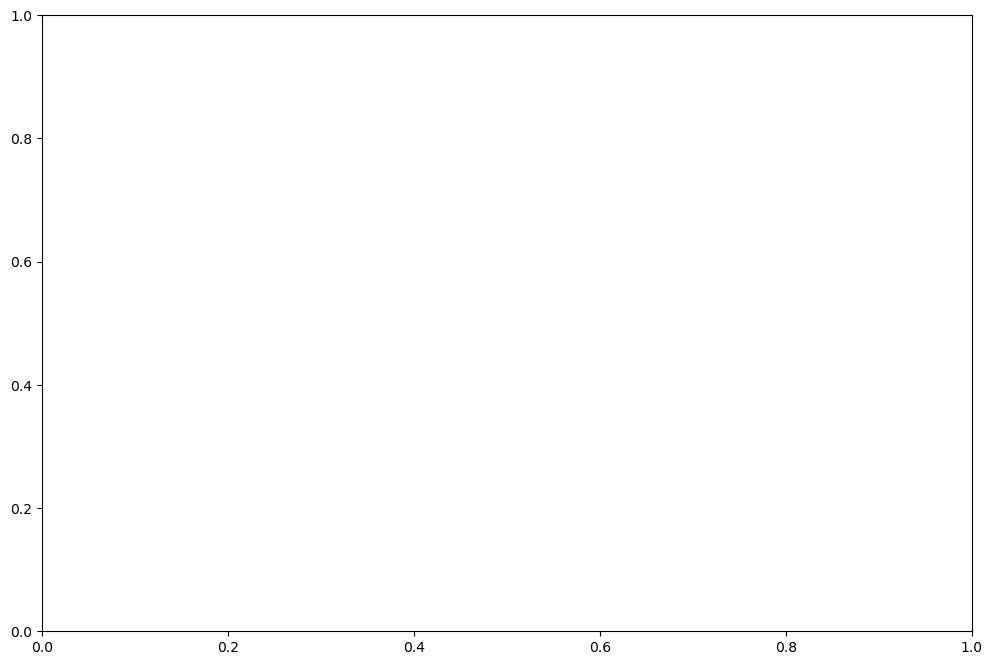

In [34]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

def plot_team_density(team_name, stadium_gdf, tracts_gdf, vmin, vmax):
    # Filter tracts for the specific team
    team_tracts = tracts_gdf[tracts_gdf['Team'] == team_name]
    
    # Get the stadium point
    stadium_point = stadium_gdf[stadium_gdf['Team'] == team_name]
    
    # Ensure we have a Point geometry
    geometry = stadium_point.geometry.values[0]
    if geometry.type == 'MultiPoint':
        geometry = list(geometry.geoms)[0]  # Take the first point
    elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
        geometry = geometry.centroid  # Use centroid for polygon geometries
    
    if not isinstance(geometry, Point):
        print(f"Error: Geometry for {team_name} is not a point and could not be converted.")
        return
    
    x, y = geometry.x, geometry.y
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot tracts with population density
    team_tracts.plot(column='population_density', cmap='viridis', legend=True, 
                     ax=ax, legend_kwds={'label': 'Population Density (people/km²)'}, vmin=vmin, vmax=vmax)
    
    # Plot stadium location using matplotlib scatter for better control over marker size
    ax.scatter(x, y, color='red', s=100, zorder=5)  # Adjust 's' for marker size (s=100 is reasonable)
    
    # Set title
    ax.set_title(f'Population Density around {team_name} Stadium', fontsize=16)
    
    # Set aspect ratio safely
    try:
        bounds = team_tracts.total_bounds
        y_coord = np.mean([bounds[1], bounds[3]])
        aspect = 1 / np.cos(y_coord * np.pi / 180)
        if np.isfinite(aspect) and aspect > 0:
            ax.set_aspect(aspect)
        else:
            ax.set_aspect('equal')
    except Exception:
        ax.set_aspect('equal')
    
    # Remove axis labels
    ax.set_axis_off()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f'global_minmax_population_density_{team_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Ensure the CRS is set correctly for both datasets
all_tracts_in_buffers = all_tracts_in_buffers.to_crs(epsg=4326)
stadiums_gdf = stadiums_gdf.to_crs(epsg=4326)

# Calculate global min and max population density
vmin = all_tracts_in_buffers['population_density'].min()
vmax = all_tracts_in_buffers['population_density'].max()

# Create a plot for each team
for team in stadiums_gdf['Team'].unique():
    try:
        plot_team_density(team, stadiums_gdf, all_tracts_in_buffers, vmin, vmax)
        print(f"Created map for {team}")
    except Exception as e:
        print(f"Error creating map for {team}: {str(e)}")

print("All team stadium density maps have been created.")

/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Arizona Diamondbacks


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Atlanta Braves


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Baltimore Orioles


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Boston Red Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Chicago Cubs


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Chicago White Sox


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Cincinnati Reds


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Cleveland Guardians


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Colorado Rockies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Detroit Tigers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Houston Astros


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Kansas City Royals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Los Angeles Angels


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Los Angeles Dodgers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Miami Marlins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Milwaukee Brewers


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Minnesota Twins


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for New York Mets


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for New York Yankees


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Oakland Athletics


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Philadelphia Phillies


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Pittsburgh Pirates


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for San Diego Padres


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for San Francisco Giants


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Seattle Mariners


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for St. Louis Cardinals


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Tampa Bay Rays


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/Users/mitchellhamilton/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Created map for Texas Rangers
Error creating map for Toronto Blue Jays: aspect must be finite and positive 


/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:15: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPoint':
/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_36755/3084638976.py:17: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the f

Created map for Washington Nationals
All team stadium density maps have been created.


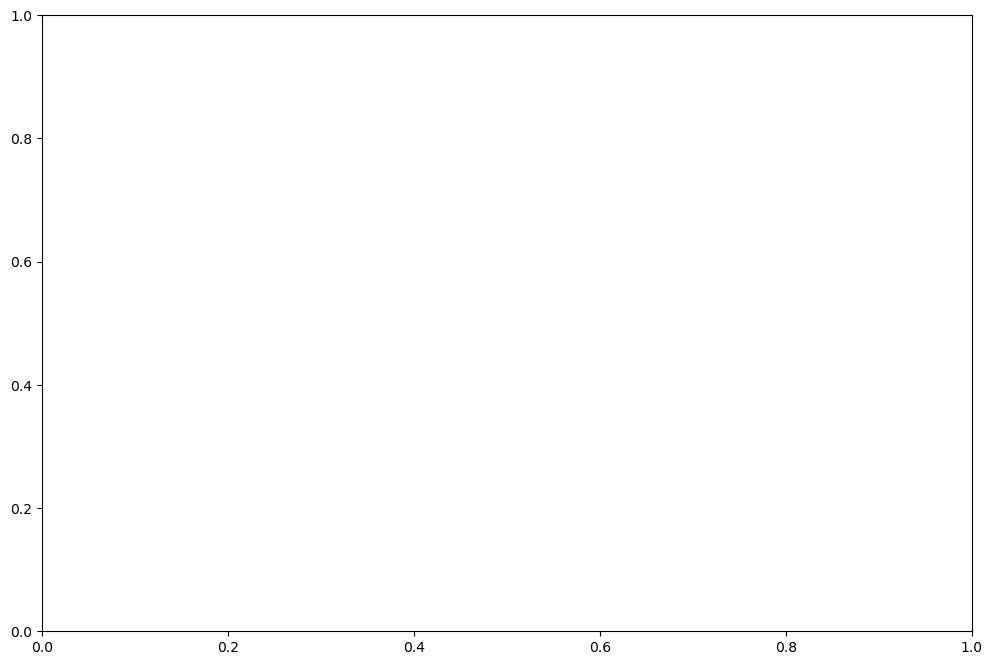

In [35]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

def plot_team_density(team_name, stadium_gdf, tracts_gdf, vmin, vmax):
    # Filter tracts for the specific team
    team_tracts = tracts_gdf[tracts_gdf['Team'] == team_name]
    
    # Get the stadium point
    stadium_point = stadium_gdf[stadium_gdf['Team'] == team_name]
    
    # Ensure we have a Point geometry
    geometry = stadium_point.geometry.values[0]
    if geometry.type == 'MultiPoint':
        geometry = list(geometry.geoms)[0]  # Take the first point
    elif geometry.type == 'Polygon' or geometry.type == 'MultiPolygon':
        geometry = geometry.centroid  # Use centroid for polygon geometries
    
    if not isinstance(geometry, Point):
        print(f"Error: Geometry for {team_name} is not a point and could not be converted.")
        return
    
    x, y = geometry.x, geometry.y
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Apply logarithmic scale to population density
    team_tracts['log_population_density'] = np.log1p(team_tracts['population_density'])
    vmin_log = np.log1p(vmin)
    vmax_log = np.log1p(vmax)
    
    # Plot tracts with population density
    team_tracts.plot(column='log_population_density', cmap='viridis', legend=True, 
                     ax=ax, legend_kwds={'label': 'Log Population Density (log(people/km²) + 1)'}, vmin=vmin_log, vmax=vmax_log)
    
    # Plot stadium location using matplotlib scatter for better control over marker size
    ax.scatter(x, y, color='red', s=100, zorder=5)  # Adjust 's' for marker size (s=100 is reasonable)
    
    # Set title
    ax.set_title(f'Population Density around {team_name} Stadium', fontsize=16)
    
    # Set aspect ratio safely
    try:
        bounds = team_tracts.total_bounds
        y_coord = np.mean([bounds[1], bounds[3]])
        aspect = 1 / np.cos(y_coord * np.pi / 180)
        if np.isfinite(aspect) and aspect > 0:
            ax.set_aspect(aspect)
        else:
            ax.set_aspect('equal')
    except Exception:
        ax.set_aspect('equal')
    
    # Remove axis labels
    ax.set_axis_off()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f'logarithmic_population_density_{team_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Ensure the CRS is set correctly for both datasets
all_tracts_in_buffers = all_tracts_in_buffers.to_crs(epsg=4326)
stadiums_gdf = stadiums_gdf.to_crs(epsg=4326)

# Calculate global min and max population density
vmin = all_tracts_in_buffers['population_density'].min()
vmax = all_tracts_in_buffers['population_density'].max()

# Create a plot for each team
for team in stadiums_gdf['Team'].unique():
    try:
        plot_team_density(team, stadiums_gdf, all_tracts_in_buffers, vmin, vmax)
        print(f"Created map for {team}")
    except Exception as e:
        print(f"Error creating map for {team}: {str(e)}")

print("All team stadium density maps have been created.")